# Pairwise Comparison for Single Environment

In this file we do a pairwise comparison for policies trained in a single environment but using different seeds and/or training algorithms.

We look at:

- Self-play
- Cross-play between policies trained with the same algorithm but different seeds
- Cross-play between policies trained with different algorithms


## Notation

- **Self-play** refers to pairings of policies that trained together
- **Cross-play** refers to pairings of policies that were not trained together

In [1]:
import os.path as osp
from typing import List, Any, Optional, Tuple
from itertools import permutations, product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import posggym

import exp_utils
import plot_utils

# Data Loading

Firstly lets load the data and do a little cleaning and setup by:

1. removing unused columns
2. add columns for agent policy training environment and reasoning level

In [2]:
rl_results_dir = 'pairwise_comparison_initseed0_numseeds1_2022-06-27_00-28-38pmhho7pe'

columns_to_drop = [
    'Unnamed: 0', 
    'episode_step_limit', 
    'time_limit', 
    'use_checkpointing',
    'search_time_mean', 
    'search_time_std', 
    'update_time_mean', 
    'update_time_std',
    'reinvigoration_time_mean', 
    'reinvigoration_time_std', 
    'policy_calls_mean', 
    'policy_calls_std', 
    'inference_time_mean', 
    'inference_time_std',
    'episode_dones',
]
rl_df = plot_utils.import_results(rl_results_dir, columns_to_drop, False)

rl_df.columns
plot_utils.validate_and_display(rl_df, False)

Agent IDs: [0 1]
Test Env: Driving7x7RoundAbout-v0
Policy K: ['-1' '0' '1' '2' '3' '4' 'BR' 'SP']
Policy Names: ['PPOPolicy_pi_0' 'PPOPolicy_pi_1' 'PPOPolicy_pi_2' 'PPOPolicy_pi_3'
 'PPOPolicy_pi_4' 'PPOPolicy_pi_BR' 'PPOPolicy_pi_SP' 'RandomPolicy']
Train Envs:: ['Driving7x7RoundAbout-v0']
Train Seeds: [0 1 2 3 4]
Train Algorithms: ['klr' 'sp']
Num rows/entries: 1850
Num experiments: 925


# The environment

Here we can see the layout for the environment. Noting that the start and destination positions for each agent changes each episode. Agents always start in a cell along the bottom or right side of the grid and have a destination in a cell along the top or left side of the grid.  

Agents can observe a rectangular area around their current location that that contains 3 cells in front, 1 behind and 1 cell to each side (total 4x3=12 cells), shown by the highlighted cells in the images. 

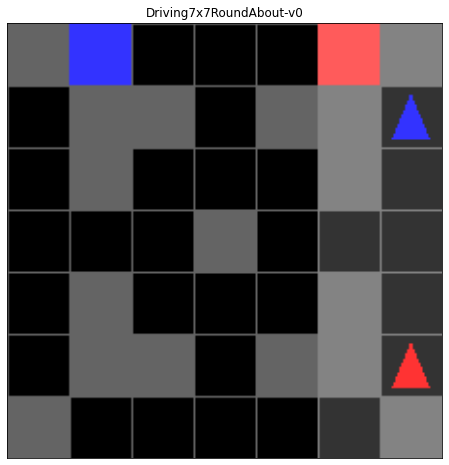

In [3]:
plot_utils.plot_environment(rl_df["env_name"].unique()[0])    
plt.show()

# Plotting

For this evaluation we have multiple degrees of variation:

1. Policy reasoning level ('K') - the reasoning level of an agent policy 
  - `BR` is the best response policy for a distribution over the policies `[-1, 0, 1, 2, 3, 4]`
  - `SP` is the policy trained using the `self-play` algorithm.
2. Train Seeds ('train_seed') - the training seed of the agent policy
  - 5 different seeds were used for each experiment
3. Training algorithm ('train_alg') - The algorithm used to train the agent policy
  - `KLR` - K-level reasoning algorithm (specifically the SyKLRBR algorithm)
  - `SP` - self-play


## Helper Functions

The following are some helper functions for later plots.

In [4]:
def get_all_rl_pw_mean_values(plot_df, y_key: str):
    policy_IDs = plot_df["K"].unique()
    policy_IDs.sort()
    
    xp_pw_returns = np.zeros((len(policy_IDs), len(policy_IDs)))
    sp_pw_returns = np.zeros((len(policy_IDs), len(policy_IDs)))

    for r, row_policy_id in enumerate(policy_IDs):
        for c, col_policy_id in enumerate(policy_IDs):
            sp_return, xp_return = plot_utils.get_mean_pairwise_values(
                plot_df,
                row_conds=[("K", "==", row_policy_id)],
                row_seed_key="train_seed",
                row_alg_key="train_alg",
                col_conds=[("K", "==", col_policy_id)],
                col_seed_key="train_seed",
                col_alg_key="train_alg",
                y_key=y_key
            )

            sp_pw_returns[r][c] = sp_return
            xp_pw_returns[r][c] = xp_return
    
    return policy_IDs, sp_pw_returns, xp_pw_returns

In [6]:
def plot_pairwise_policy_comparison(plot_df, 
                                    y_key: str,
                                    vrange=None,
                                    figsize=(20, 20),
                                    valfmt=None):
    """Plot results for each policy-seed pairings.
    
    This produces a grid of (grid)-plots:
    
    Outer-grid: train seed X train seed
    Inner-grid: K X K
    
    """
    train_seeds = plot_df["train_seed"].unique()
    train_seeds.sort()
    
    policy_ids = plot_df["K"].unique()
    policy_ids.sort()
    
    agent_ids = plot_df["agent_id"].unique()
    agent_ids.sort()
    
    fig, axs = plt.subplots(nrows=len(train_seeds), ncols=len(train_seeds), figsize=(20, 20))
    for row_seed_idx, row_seed in enumerate(train_seeds):
        for col_seed_idx, col_seed in enumerate(train_seeds):
            pw_values = np.zeros((len(policy_ids), len(policy_ids)))
            for col_policy_idx, col_policy_id in enumerate(policy_ids):
                for row_policy_idx, row_policy_id in enumerate(policy_ids):
                    ys = []
                    for (a0, a1) in permutations(agent_ids):
                        col_policy_df = plot_utils.filter_exps_by(
                                plot_df,
                                [
                                    ("agent_id", "==", a0), 
                                    ("train_seed", "==", col_seed),
                                    ("K", "==", col_policy_id)
                                ]
                        )
                        pairing_df = plot_utils.filter_by(
                            col_policy_df,
                            [
                                ("agent_id", "==", a1), 
                                ("train_seed", "==", row_seed),
                                ("K", "==", row_policy_id)
                            ]
                        )
                        pairing_y_vals = pairing_df[y_key].unique()
                        pairing_y_vals.sort()
                    
                        if len(pairing_y_vals) == 1:
                            ys.append(pairing_y_vals[0])
                        elif len(pairing_y_vals) > 1:
                            print("More than 1 experiment found for pairing:")
                            print(
                                f"(pi={row_policy_id}, seed={row_seed}, agent_id={a1}) vs "
                                f"(pi={col_policy_id}, seed={col_seed}, agent_id={a0}): {pairing_y_vals}"
                            )
                            print("Plotting only the first value.")
                            ys.append(pairing_y_vals[0])
                                
                    if len(ys) == 0:
                        y = np.nan
                    else:
                        y = np.mean(ys)
                        
                    if y is not np.nan and valfmt is None:
                        if isinstance(y, float):
                            valfmt = "{x:.2f}"
                        if isinstance(y, int):
                            valfmt = "{x}"
                    
                    pw_values[row_policy_idx][col_policy_idx] = y
            
            ax = axs[row_seed_idx][col_seed_idx]
            plot_utils.plot_pairwise_heatmap(
                ax, (policy_ids, policy_ids), pw_values, title=None, vrange=vrange, valfmt=valfmt
            )
            
            if row_seed_idx == 0:
                ax.set_title(col_seed_idx)
            if col_seed_idx == 0:
                ax.set_ylabel(row_seed_idx)
                    

In [7]:
def plot_rl_pw_comparison(plot_df, y_key: str, vrange: Optional[Tuple[float, float]] = None):
    policy_ids, sp_values, xp_values = get_all_rl_pw_mean_values(plot_df, y_key)
    
    if vrange is None:
        min_value = np.nanmin([np.nanmin(sp_values), np.nanmin(xp_values)])
        max_value = np.nanmax([np.nanmax(sp_values), np.nanmax(xp_values)])
        vrange = (min_value, max_value)

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
    plot_utils.plot_pairwise_heatmap(axs[0], (policy_ids, policy_ids), sp_values, title=f"Same-Play")
    plot_utils.plot_pairwise_heatmap(axs[1], (policy_ids, policy_ids), xp_values, title=f"Cross-Play")

    pw_diff = sp_values - xp_values
    plot_utils.plot_pairwise_heatmap(
        axs[2], 
        (policy_ids, policy_ids), 
        pw_diff, 
        title=f"Difference", 
        vrange=(np.nanmin(pw_diff), np.nanmax(pw_diff))
    )

    fig.tight_layout()
    fig.suptitle(y_key)
    # fig.savefig(osp.join(exp_utils.EXP_BASE_DIR, "figures", "pw_rl_performance.png"))
    plt.show()

## RL Pairwise Policy Performance

Here we look at the performance for each possible pairing of (policy_id, train_seed).

For each performance metric we have a grid of (grid)-plots:
    
- Outer-grid: train seed X train seed
- Inner-grid: policy_id X policy_id

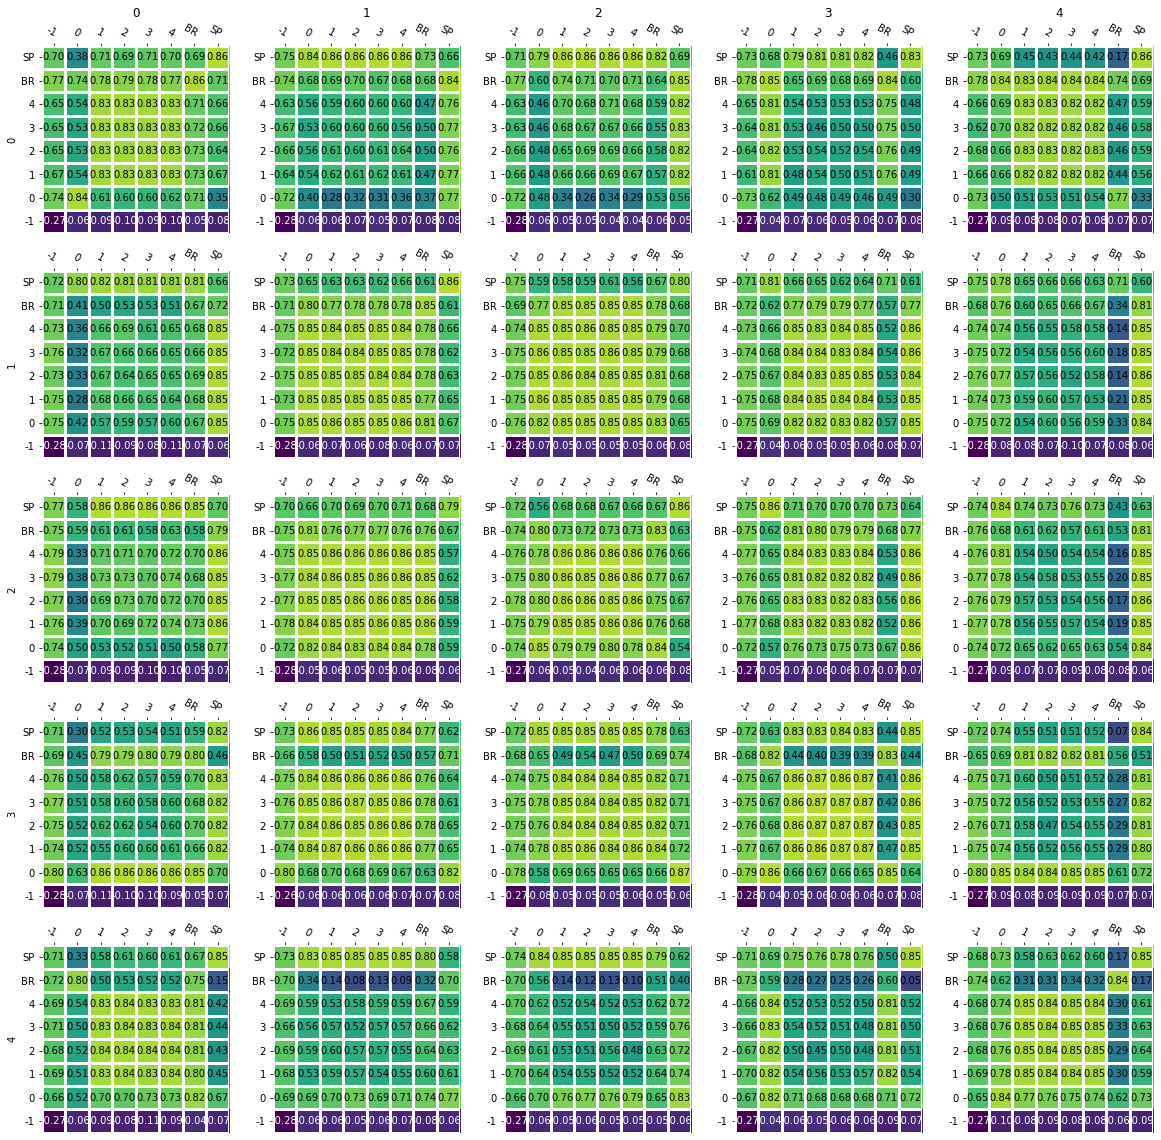

In [8]:
plot_pairwise_policy_comparison(
    rl_df, y_key="episode_discounted_returns_mean", vrange=(-0.2, 1.0), figsize=(20, 20), valfmt="{x:.2f}"
)

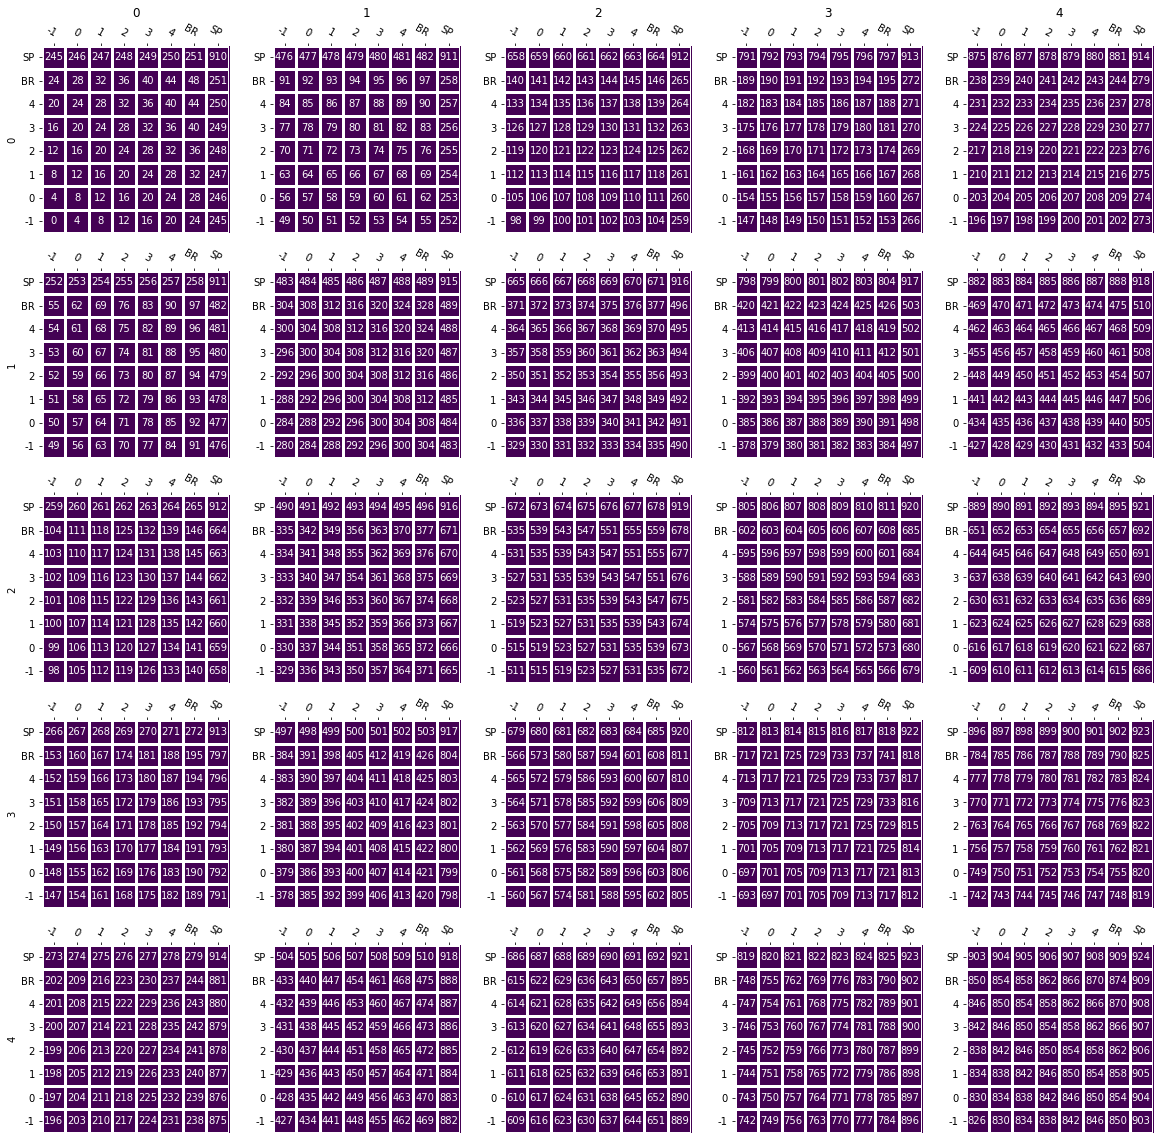

In [9]:
plot_pairwise_policy_comparison(rl_df, y_key="exp_id", vrange=(0.0, 0.0), figsize=(20, 20), valfmt="{x:.0f}")

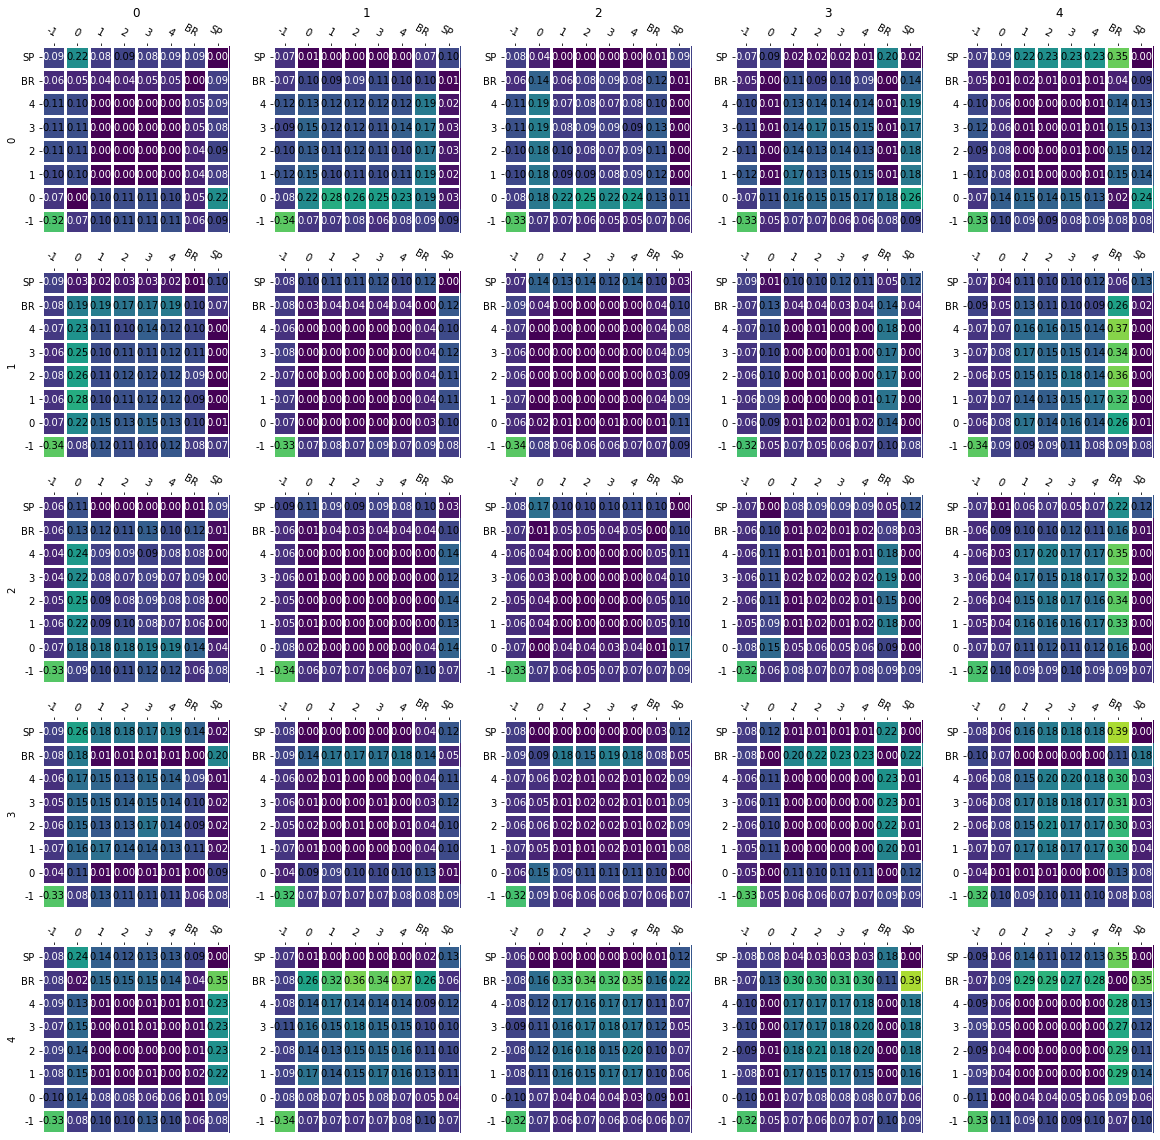

In [12]:
plot_pairwise_policy_comparison(
    rl_df, y_key="prop_LOSS", vrange=(0.0, 0.45), figsize=(20, 20), valfmt="{x:.2f}"
)

## RL average policy performance

Here look at average performance of the policies learned using RL by themselves (without additional search).

Each plot shows the *mean discounted episode return* for the *row* policy against the *column* policy.

The **left-hand plot** shows *same-play* performance. So performance of policies against policies from the same training population (same training algorithm and same seed).

The **middle plot** shows *cross-play* performance. So performance of policies against policies from different training populations (against policies trained using a different algorithm and/or different seed).

The **right-hand plot** shows the generalization gap which is just the difference between the *Same-Play* and *Cross-Play* performance.

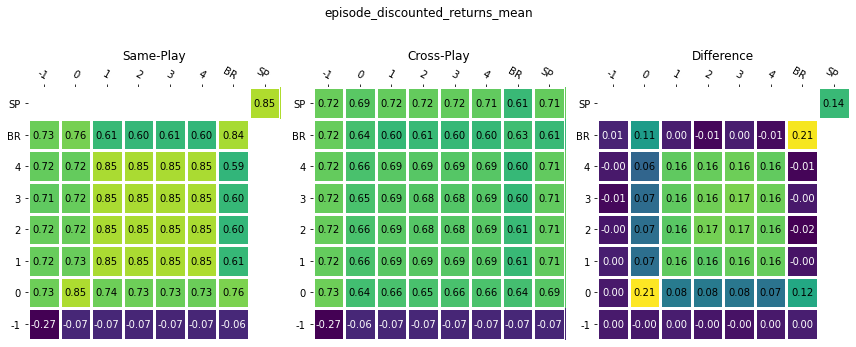

In [17]:
plot_rl_pw_comparison(rl_df, "episode_discounted_returns_mean", vrange=(-0.2, 1.0))
plt.show()

The next set of plots show the *Proportion of episodes the row agent reached it's goal*. I.e. the success rate.

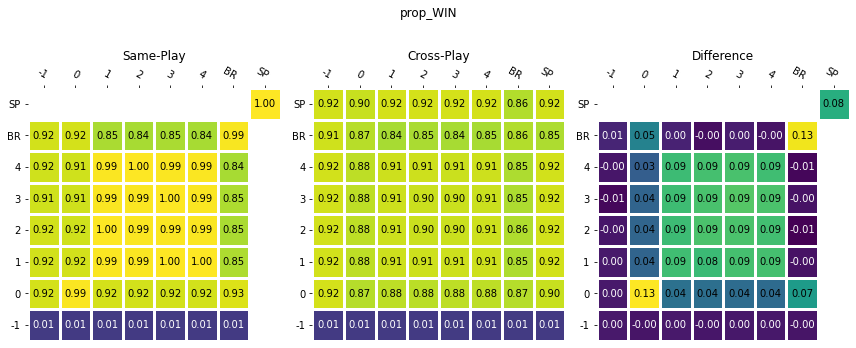

In [23]:
plot_rl_pw_comparison(rl_df, "prop_WIN", vrange=(0.0, 1.0))
plt.show()

The next set of plots show the *Proportion of episodes the row agent crashed*. I.e. the collision rate.

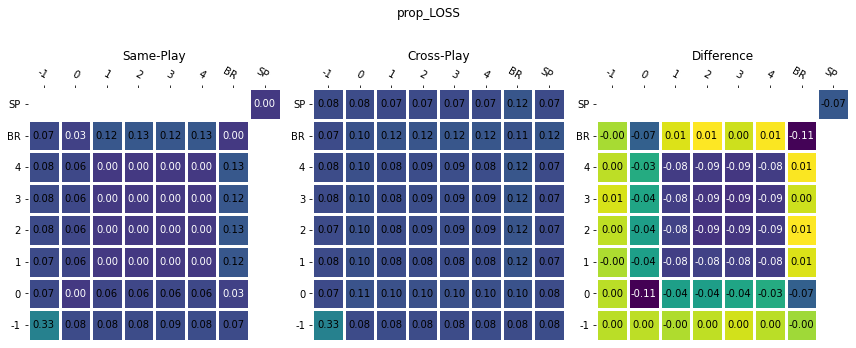

In [24]:
plot_rl_pw_comparison(rl_df, "prop_LOSS", vrange=(0.0, 0.4))
plt.show()